# **Stereo Triangulation YoloV8 output**
***

In [1]:
import numpy as np
import cv2
from ultralytics import YOLO
import torch
import yolov8_postprocessing

***
**Laden der Bilder**

In [2]:
img1 = r"/home/mo/YoloV8_InstanceSeg/dataset_1/image_1735916671.png"
img2 = r"/home/mo/YoloV8_InstanceSeg/dataset_1/image_1735916696.png"

In [3]:
inp1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
inp2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)

inp1 = cv2.cvtColor(inp1, cv2.COLOR_GRAY2BGR)
inp2 = cv2.cvtColor(inp2, cv2.COLOR_GRAY2BGR)

***
**Inferenz**

In [4]:
model_path = r"/home/mo/YoloV8_InstanceSeg/runs/train/nano/full_set/20250119_1052/weights/best.pt"

model = YOLO(model_path)
print("Model loaded!") if model is not None else print("ERROR - Model not loaded!")

use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = "cuda"
    print("Using GPU!\n\n")
    !nvidia-smi
else:
    device = "cpu"
    print("Using CPU!")

Model loaded!
Using GPU!


Sun Jan 19 22:27:17 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P5              20W /  80W |     84MiB /  8192MiB |     24%      Default |
|                                         |                      |                  N/A |
+----------------------------------------

In [5]:
confidence_threshold = 0.4

def inf(inp, model):
    return model.predict(source = inp,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            # max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)

In [7]:
out1 = inf(inp1, model)
out2 = inf(inp2, model)


0: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 bar, 6 hooks, 4 tips, 5 lowpoints, 6.4ms
Speed: 1.4ms preprocess, 6.4ms inference, 3.0ms postprocess per image at shape (1, 3, 352, 640)


***
**Postprocessing**

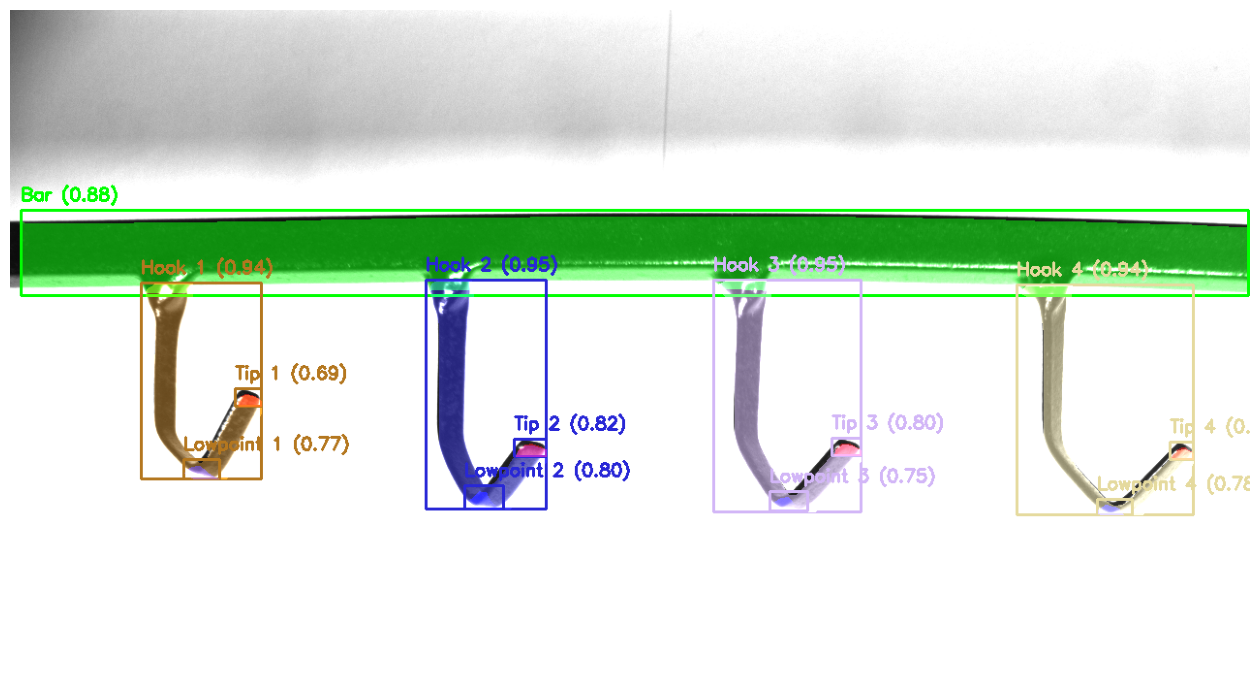

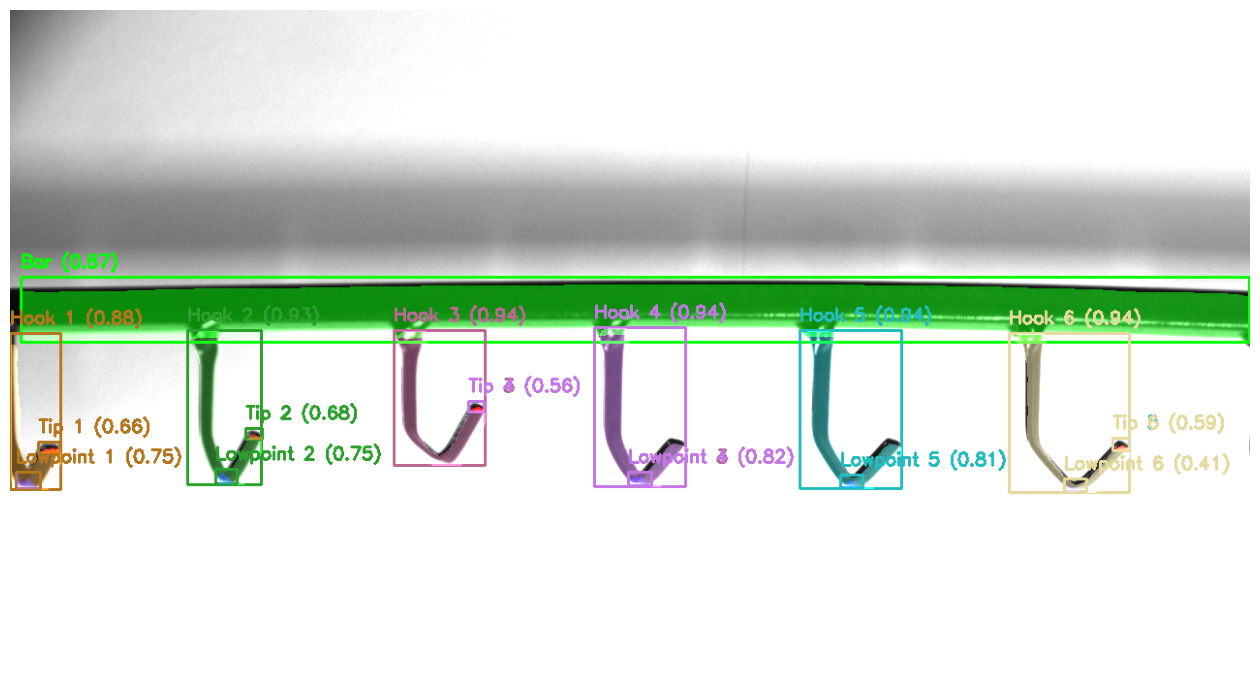

In [8]:
inp1_bar_dict, inp1_hooks_dict = yolov8_postprocessing.postprocess(results=out1, input=inp1, plot_result=True)
inp2_bar_dict, inp2_hooks_dict = yolov8_postprocessing.postprocess(results=out2, input=inp2, plot_result=True)

In [9]:
hook_inp1 = inp1_hooks_dict['hook_2']
hook_inp2 = inp2_hooks_dict['hook_2']

In [10]:
def calc_midpoint_of_box(box):
    x1, y1, x2, y2 = box
    return [(x1+x2)/2, (y1+y2)/2]

In [11]:
hook_inp1['uv_hook'] = calc_midpoint_of_box(hook_inp1['tip_box'])
hook_inp1['uv_tip'] = calc_midpoint_of_box(hook_inp1['hook_box'])
hook_inp1['uv_lowpoint'] = calc_midpoint_of_box(hook_inp1['lowpoint_box'])

hook_inp2['uv_hook'] = calc_midpoint_of_box(hook_inp2['tip_box'])
hook_inp2['uv_tip'] = calc_midpoint_of_box(hook_inp2['hook_box'])
hook_inp2['uv_lowpoint'] = calc_midpoint_of_box(hook_inp2['lowpoint_box'])

print("Hook coordinates [px] in img 1:")
print(hook_inp1['uv_hook'])
print(hook_inp1['uv_tip'])
print(hook_inp1['uv_lowpoint'])

print("\nHook coordinates [px] in img 2:")
print(hook_inp2['uv_hook'])
print(hook_inp2['uv_tip'])
print(hook_inp2['uv_lowpoint'])

Hook coordinates [px] in img 1:
[537.1793823242188, 452.3701171875]
[491.5838928222656, 397.42059326171875]
[489.45501708984375, 503.48553466796875]

Hook coordinates [px] in img 2:
[252.17349243164062, 438.2674560546875]
[221.41329956054688, 410.8692321777344]
[223.60330200195312, 482.12823486328125]


***
**Stereo Triangulation**

In [16]:
baseline = 0.01        # in m

c_x = 0
c_y = 0

s_mm_per_px = 3.45e-6
f = 0.008 / s_mm_per_px
print("Focal length in px: ", f)

intrinsics = [[f, 0, c_x], [0, f, c_y], [0, 0, 1]]

Focal length in px:  2318.840579710145


In [17]:
def triangulate(p1, p2, baseline, intrinsics):
    d = p1[0] - p2[0]
    return baseline * intrinsics[0][0] / d

def calc_real_point(p_in_px, depth, intrinsics):
    return depth * (np.linalg.inv(intrinsics) @ [p_in_px[0], p_in_px[1], 1])

In [18]:
z_hook = triangulate(hook_inp1['uv_hook'], hook_inp2['uv_hook'], baseline=baseline, intrinsics=intrinsics)
z_tip = triangulate(hook_inp1['uv_tip'], hook_inp2['uv_tip'], baseline=baseline, intrinsics=intrinsics)
z_lowpoint = triangulate(hook_inp1['uv_lowpoint'], hook_inp2['uv_lowpoint'], baseline=baseline, intrinsics=intrinsics)

print("Depth z of hook: ", z_hook)
print("Depth z of tip: ", z_tip)
print("Depth z of lowpoint: ", z_lowpoint)

Depth z of hook:  0.0813611459252348
Depth z of tip:  0.08582875551758683
Depth z of lowpoint:  0.08722308144386189


In [21]:
xyz_hook = calc_real_point(p_in_px=hook_inp1['uv_hook'], depth=z_hook, intrinsics=intrinsics)
xyz_tip = calc_real_point(p_in_px=hook_inp1['uv_tip'], depth=z_tip, intrinsics=intrinsics)
xyz_lowpoint = calc_real_point(p_in_px=hook_inp1['uv_lowpoint'], depth=z_lowpoint, intrinsics=intrinsics)

print("Real coordinates of hook [m]: ", xyz_hook)
print("Real coordinates of tip [m]: ", xyz_tip)
print("Real coordinates of lowpoint [m]: ", xyz_lowpoint)

Real coordinates of hook [m]:  [   0.018848    0.015872    0.081361]
Real coordinates of tip [m]:  [   0.018195     0.01471    0.085829]
Real coordinates of lowpoint [m]:  [   0.018411    0.018939    0.087223]
